In [5]:
import importlib

import data_frame
import models

In [396]:
importlib.reload(data_frame)
importlib.reload(models)

filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
model_path = f"../../models/experiment2/BNN_last_3_layers_2/variables/variables"
df = data_frame.DataFrame(filePath, "QSO",)

config = {"num_components":3}
bnn = models.MLModelContext(strategy=models.BayesianNN(df, config))
bnn.load_weights(model_path)

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
model_path = f"../../models/experiment2/MG_3_components_3/variables/variables"

gmm = models.MLModelContext(strategy=models.MixtureGaussian(df, config))
gmm.load_weights(model_path)

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_vari

In [397]:
objects = np.linspace(500, 19500, 20, dtype=int)

scaler = bnn.strategy.scaler
X_test, y_test = bnn.strategy.X_test, bnn.strategy.y_test
X_test.dropna(inplace=True)
X_test.sort_values(by=["MAG_GAAP_r"], inplace=True)

points = np.arange(0,4,0.01)

bnn_net = bnn.strategy.network
gmm_net = gmm.strategy.network

bnn_points = []
gmm_points = []
for n in objects:
    y_pred = y_test[n:n+1]
    r_mag = X_test.iloc[n:n+1, 2].item()

    feat = scaler.transform(X_test[n:n+1])
    # BNN
    all_means = []
    all_probs = []
    
    for _ in range(100):
        dist = bnn_net(feat)
        all_means.append(dist.mean())
        all_probs.append([np.exp(dist.log_prob(point)) for point in points])
    
    bnn_points.append((np.mean(all_probs, axis=0), np.mean(all_means), y_pred, r_mag))
    
    # GMM
    dist = gmm_net(feat)
    gmm_points.append(([np.exp(dist.log_prob(point)) for point in points], dist.mean(), y_pred, r_mag))

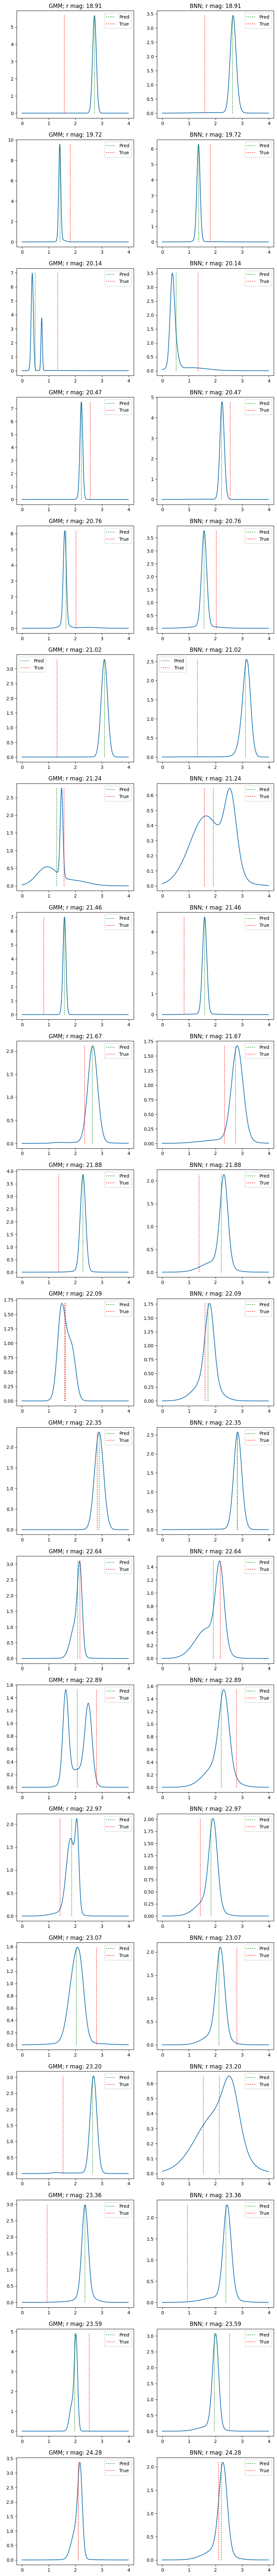

In [398]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(20,2, figsize=(10,100))

for i in range(20):
    axes[i][0].plot(points, gmm_points[i][0])
    axes[i][0].vlines(x = gmm_points[i][1], ymin=0, ymax=np.max(gmm_points[i][0]), colors="green", linestyles="dotted", label="Pred")
    axes[i][0].vlines(x = gmm_points[i][2], ymin=0, ymax=np.max(gmm_points[i][0]), colors="red", linestyles="dotted", label="True")
    axes[i][0].legend()
    axes[i][0].set_title(f"GMM; r mag: {gmm_points[i][3]:.2f}")
    
    axes[i][1].plot(points, bnn_points[i][0])
    axes[i][1].vlines(x = bnn_points[i][1], ymin=0, ymax=np.max(bnn_points[i][0]), colors="green", linestyles="dotted", label="Pred")
    axes[i][1].vlines(x = bnn_points[i][2], ymin=0, ymax=np.max(bnn_points[i][0]), colors="red", linestyles="dotted", label="True")
    axes[i][1].legend()
    axes[i][1].set_title(f"BNN; r mag: {bnn_points[i][3]:.2f}")

plt.subplots_adjust(hspace=0.2)
plt.show()